In [1]:
from joblib import dump
from pathlib import Path
import random

# from cloudpathlib import S3Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pyvips
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys

sys.path.append('..')
from config import CFG
CFG = CFG()

In [2]:
Image.MAX_IMAGE_PIXELS = None

In [3]:
train_metadata = pd.read_csv(f'{CFG.DATA_PATH}/train_metadata.csv', index_col='filename')
train_labels = pd.read_csv(f'{CFG.DATA_PATH}/train_labels.csv', index_col="filename")
train_labels.relapse.value_counts(dropna=False)

0    1129
1     213
Name: relapse, dtype: int64

In [4]:
# select a set of images to plot
SEED = 42
NUM_IMAGES = 3

# we'll use the US url
selected_image_paths = train_metadata.sample(
    random_state=SEED, n=NUM_IMAGES
).us_tif_url.values

In [12]:
def visualize_page(page_num, image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(10, 10))
    fig.tight_layout()

    for n, image_s3_path in enumerate(image_paths):
        fname = image_s3_path.split('/')[-1]
        !s5cmd --no-sign-request cp {image_s3_path} {CFG.DATA_PATH + '/baseline'}
        print(f"Downloading {fname}")
        local_file = f'{CFG.DATA_PATH}/baseline/{fname}'

        n_frames = Image.open(local_file).n_frames
        img = pyvips.Image.new_from_file(local_file, page=page_num).numpy()

        axes[n].set_title(f"{fname}, page={page_num}\n {img.shape}\n")
        axes[n].imshow(img)

        del local_file

cp s3://drivendata-competition-visiomel-public-us/images/cgsctzbm.tif /mnt/disk1/visiomel-melanoma-runtime/data/baseline/cgsctzbm.tif
cp s3://drivendata-competition-visiomel-public-us/images/ljhglzot.tif /mnt/disk1/visiomel-melanoma-runtime/data/baseline/ljhglzot.tif
cp s3://drivendata-competition-visiomel-public-us/images/9v0bl8q7.tif /mnt/disk1/visiomel-melanoma-runtime/data/baseline/9v0bl8q7.tif


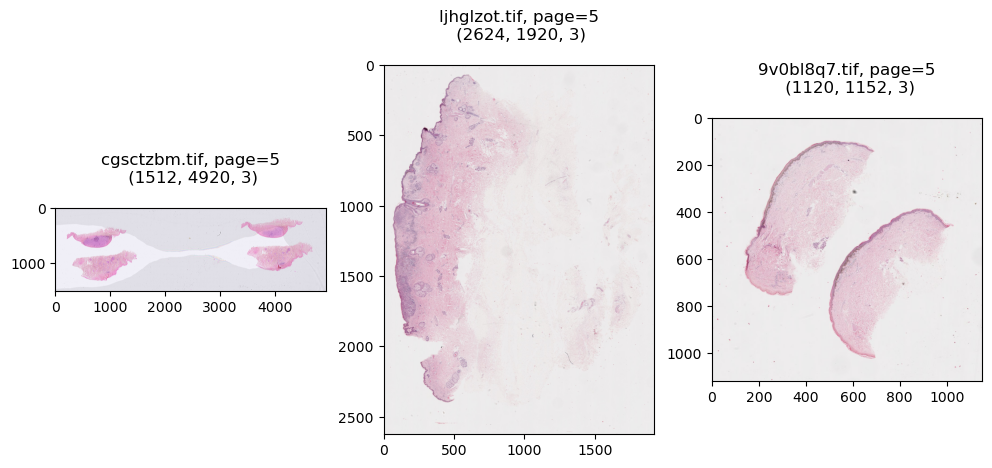

In [11]:
visualize_page(5, selected_image_paths)

cp s3://drivendata-competition-visiomel-public-us/images/cgsctzbm.tif /mnt/disk1/visiomel-melanoma-runtime/data/baseline/cgsctzbm.tif
cp s3://drivendata-competition-visiomel-public-us/images/ljhglzot.tif /mnt/disk1/visiomel-melanoma-runtime/data/baseline/ljhglzot.tif
cp s3://drivendata-competition-visiomel-public-us/images/9v0bl8q7.tif /mnt/disk1/visiomel-melanoma-runtime/data/baseline/9v0bl8q7.tif


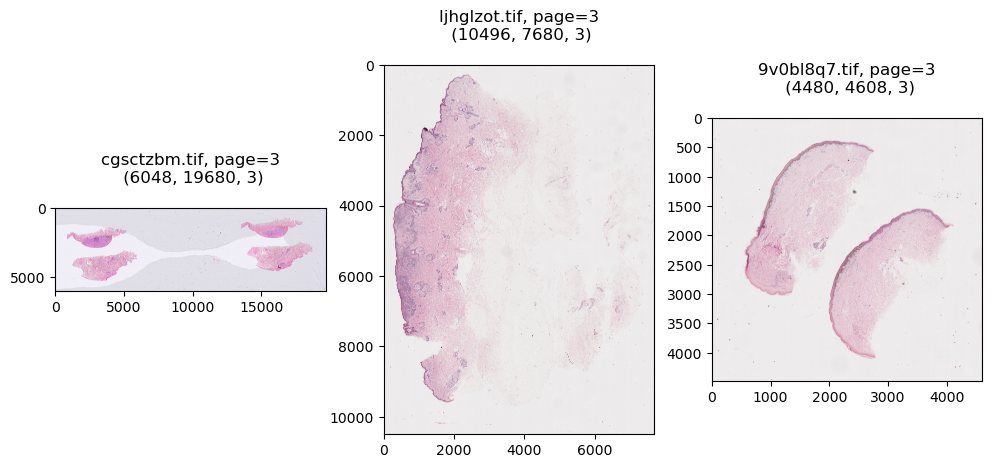

In [13]:
visualize_page(3, selected_image_paths)

In [14]:
# define an encoder for melanoma_history

enc = OneHotEncoder(drop="first", sparse_output=False)
enc.fit(np.array(train_metadata["melanoma_history"]).reshape(-1, 1))
enc.get_feature_names_out()

array(['x0_YES', 'x0_nan'], dtype=object)

In [15]:
def preprocess_feats(df=train_metadata):
    feats = df.copy()
    # take the first age in the range and convert to integer
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    X = pd.concat(
        [
            feats[["age_int", "sex"]],
            pd.DataFrame(
                enc.transform(np.array(feats["melanoma_history"]).reshape(-1, 1)),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )

    return X

In [16]:
# preprocess features

X = preprocess_feats(train_metadata)
y = train_labels.relapse
X

,age_int,sex,x0_YES,x0_nan
filename,,,,
1u4lhlqb.tif,32,2,1.0,0.0
rqumqnfp.tif,46,1,0.0,0.0
bu5xt1xm.tif,64,2,0.0,0.0
dibvu7wk.tif,62,2,0.0,1.0
qsza4coh.tif,90,2,0.0,0.0
...,...,...,...,...
n7jd638y.tif,68,1,0.0,1.0
8wg601oe.tif,66,1,0.0,1.0
1ejfd01b.tif,80,1,0.0,1.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train

,age_int,sex,x0_YES,x0_nan
filename,,,,
f9oktt5o.tif,54,2,0.0,0.0
rdvuvi1x.tif,66,2,0.0,0.0
o37l6qb1.tif,58,1,0.0,1.0
2bg6adrf.tif,80,2,0.0,1.0
031viy0y.tif,28,2,0.0,0.0
...,...,...,...,...
mhcm6bc6.tif,44,2,0.0,1.0
t013dhcf.tif,58,1,0.0,0.0
t1bsrqwq.tif,74,1,0.0,1.0


In [18]:
# fit a calibrated random forest model

rf = RandomForestClassifier(random_state=SEED)
calibrated_rf = CalibratedClassifierCV(rf, method="sigmoid", cv=5)
calibrated_rf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42))

In [19]:
def score(y_true, y_pred):
    return log_loss(y_true, y_pred, eps=1e-16)

In [20]:
preds = calibrated_rf.predict_proba(X_test)[:, 1]
score(y_test, preds)

0.4378480226166271

In [21]:
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
preds = rf.predict_proba(X_test)[:, 1]
score(y_test, preds)

1.4784049553641676

In [22]:
# train on entire dataset

rf = RandomForestClassifier(random_state=SEED)
calibrated_rf = CalibratedClassifierCV(rf, method="sigmoid", cv=5)
calibrated_rf.fit(X, y)

CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42))

In [25]:
Path("../submission/assets").mkdir(exist_ok=True, parents=True)

# save out model to assets directory in submission folder
dump(calibrated_rf, "../submission/assets/random_forest_model.joblib")

# save out encoder to assets directory as well
dump(enc, "../submission/assets/history_encoder.joblib")

['../submission/assets/history_encoder.joblib']

In [27]:
%%writefile ../submission/main.py

"""Solution for VisioMel Challenge"""

from joblib import load
from pathlib import Path

from loguru import logger
import numpy as np
import pandas as pd


DATA_ROOT = Path("/code_execution/data/")


def preprocess_feats(df, enc):
    feats = df.copy()
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    X = pd.concat(
        [
            feats[["age_int", "sex"]],
            pd.DataFrame(
                enc.transform(np.array(feats["melanoma_history"]).reshape(-1, 1)),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )
    return X
    
    
def main():
    # load sumission format
    submission_format = pd.read_csv(DATA_ROOT / "submission_format.csv", index_col=0)
    
    # load test_metadata
    test_metadata = pd.read_csv(DATA_ROOT / "test_metadata.csv", index_col=0)
    
    logger.info("Loading feature encoder and model")
    calibrated_rf = load("assets/random_forest_model.joblib")
    history_encoder = load("assets/history_encoder.joblib")
    
    logger.info("Preprocessing features")
    processed_features = preprocess_feats(test_metadata, history_encoder)
        
    logger.info("Checking test feature filenames are in the same order as the submission format")
    assert (processed_features.index == submission_format.index).all()
    
    logger.info("Checking test feature columns align with loaded model")
    assert (processed_features.columns == calibrated_rf.feature_names_in_).all()
    
    logger.info("Generating predictions")
    submission_format["relapse"] = calibrated_rf.predict_proba(processed_features)[:,1]

    # save as "submission.csv" in the root folder, where it is expected
    logger.info("Writing out submission.csv")
    submission_format.to_csv("submission.csv")


if __name__ == "__main__":
    main()

Writing ../submission/main.py


In [30]:
# zip up submission
! cd ../submission; zip -r ../submission.zip ./*

  adding: assets/ (stored 0%)
  adding: assets/history_encoder.joblib (deflated 52%)
  adding: assets/random_forest_model.joblib (deflated 82%)
  adding: main.py (deflated 60%)
